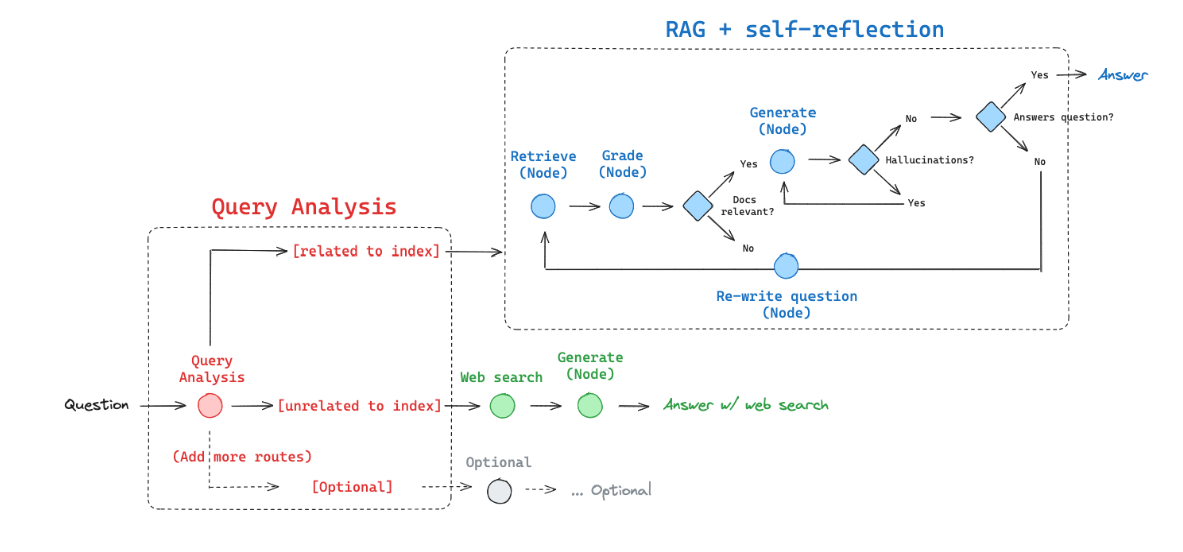# Adaptive RAG

Adaptive RAG is a strategy for RAG that unites (1) [query analysis](https://blog.langchain.dev/query-construction/) with (2) [active / self-corrective RAG](https://blog.langchain.dev/agentic-rag-with-langgraph/).

In the [paper](https://arxiv.org/abs/2403.14403), they report query analysis to route across:

* No Retrieval
* Single-shot RAG
* Iterative RAG

Let's build on this using LangGraph.

In our implementation, we will route between:

* Web search: for questions related to recent events
* Self-corrective RAG: for questions related to our index

code walkthrough video 1 : https://www.youtube.com/watch?v=8UZCmQ8hP9c
video 2 : https://www.youtube.com/watch?v=hFOyhqGabR0
video 3 : https://www.youtube.com/watch?v=7h6uDsfD7bg

In [ ]:
# %%capture --no-stderr
%pip install -U langchain_community tiktoken langchain-openai langchain-cohere langchain-chroma langchainhub langchain langgraph  tavily-python bs4 pypdf

In [2]:
### LLMs
import os

os.environ["OPENAI_API_KEY"] = "sk-xxxx"
# os.environ["COHERE_API_KEY"] = "xxxx"
os.environ["SEARCHAPI_API_KEY"] = "xxxx"

## Index

In [ ]:
### Build Index
import operator
from typing import List, TypedDict, Sequence, Annotated
from langchain_core.messages import BaseMessage
from langchain.prompts.chat import ChatPromptTemplate
from langchain_openai import ChatOpenAI
# from langchain_community.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langgraph.graph import END, StateGraph, START
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import TokenTextSplitter, RecursiveCharacterTextSplitter

from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain import hub
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

In [4]:
llm = ChatOpenAI(model="gpt-4-turbo")

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
embedding = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

# embedding = embedding
# embedding = OpenAIEmbeddings()

c:\ProgramData\anaconda\envs\langgraph\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Create VectorDB

In [ ]:
# # load single pdf
# pdf_path = 'ViT.pdf'
# loader = PyPDFLoader(pdf_path)
# pages = loader.load_and_split()
# len(pages)embeddings_mini = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2',
#                                    model_kwargs={'device': 'cpu'})

# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=500,
#     chunk_overlap=50,
# )
# documents = text_splitter.split_documents(pages)
# len(documents)

# embeddings = embeddings_mini
# persist_directory = 'db'


# vectordb = Chroma.from_documents(documents = documents,
#                                  embedding = embeddings,
#                                  persist_directory = persist_directory)
# vectordb = None


# # Now we can load the persisted database from disk, and use it as normal.
# vectordb = Chroma(persist_directory=persist_directory,
#                   embedding_function=embeddings)
# vectordb


# retriever = vectordb.as_retriever(search_kwargs={'k': 3})
# docs = retriever.get_relevant_documents("What is the Vision Transformer (ViT) model?")
# len(docs), docs

## Create Lang Graph

In [ ]:
class GraphState(TypedDict):
    llm_openai: ChatOpenAI
    emb_model: OpenAIEmbeddings
    question: str
    on_topic: bool
    # llm_output: str
    generated_queries: list[str]
    generated_query_num: int
    integration_query: str
    rewritten_query: str
    # message: Annotated[Sequence[BaseMessage], operator.add]
    message: list[str]
    fusion_documents: list[Document]
    grade: list[str]
    No_of_query_rewriting_trials: int
    No_of_hallucination_trials: int
    No_of_answer_relevance_trials: int

In [ ]:
def question_relevance(state: GraphState) -> GraphState:
    print("\n --- Question Classifier --- \n")
    print("#question ")
    question = state['question']   
    print("##question ", question)
    # llm = ChatOpenAI(model="gpt-4-turbo")
    
    system_prompt = """You are a grader assessing the relevance of the user question. \n
        Go through the paper, summarize it and then answer the question. Only answer if the question is about one of the following topics:
        1. Information about the research paper.
        2. Information about the paper titles, abstract, introduction, conclusion,  future scopes.
        3. Information related to methodology used.
        4. academic questions.
        5. Vision Transformer (ViT) model.
        6. Abstract, Introduction, Conclusion, Future Scopes.

        If the question IS about these topics response with "Yes", otherwise respond with "No".
        """
    human_prompt = """
    User question: {question}
      
    """
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", human_prompt),
        ]
    )

    # structured_llm = llm.with_structured_output(GradeQuestion)
    classifier_chain = grade_prompt | llm | StrOutputParser()
    # grader_llm = grade_prompt | structured_llm
    result = classifier_chain.invoke({"question": question})
    print("result ", result)
    state["on_topic"] = result
    return state


def on_topic_router(state: StateGraph):
    print("\n --- On Topic Router --- \n")
    on_topic = state["on_topic"]
    print("on_topic ", on_topic)
    if on_topic.lower() == "yes":
        return "on_topic"
    else:
        return "off_topic"


def off_topic_response(state):
    print("\n --- Off Topic Response --- \n")
    state['message'] = ["I can't respond to that! Please write a appropriate question."]
    return state

In [ ]:
def generate_queries(state:GraphState) -> GraphState:
  
    print("--- generated_queries ---")
    # llm = state['llm_openai']
    # llm = ChatOpenAI(model="gpt-4-turbo")
    question = state['question']
    print("question", question)
    generate_queries_num = state['generated_query_num']
    system_prompt = "You are an assistant that generate multiple search queries based on a single input query."
    human_prompt = """When creating queries, output each query on a new line without significantly changing the original query's meaning.
    Input query: {question}
    Generate_queries_num: {generate_queries_num} 
    output queries: 
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", human_prompt),
        ]
    )
    question_chain = prompt | llm | StrOutputParser() | (lambda x: x.split("\n"))
    generate_queries = question_chain.invoke(
        {"question": question,
         "generate_queries_num": generate_queries_num
         }
    )
    generate_queries.insert(0, "0. " + question)
    print("\nOriginal Question + Generated Questions =====================")
    for i, query in enumerate(generate_queries):
        print(f"\n{query}")
    print("\n===========================================\n")
    state["generated_queries"] = generate_queries
    return state


In [ ]:
DOCUMENT_PDF = "ViT.pdf"
def retrieve(state:GraphState) -> GraphState:
    print("--- retrieve ---")
    # print(state)

    generated_queries = state['generated_queries']
    raw_documents = PyPDFLoader(DOCUMENT_PDF).load()

    #Define chunking strategy
    text_splitter = TokenTextSplitter(chunk_size=2048, chunk_overlap=24)
    #Split the documents
    documents = text_splitter.split_documents(raw_documents)

    # print("Original documents: ", len(documents), "documents ", documents)

    #chroma db
    embeddings = embedding
    vector_db = Chroma.from_documents(documents, collection_name="rag-chroma", embedding=embeddings)

    fusion_documents = []
    for question in generated_queries:
        docs = vector_db.similarity_search(question, k=3)
        fusion_documents.append(docs)
    
    # print("\nfusion_documents ", fusion_documents)
    state['fusion_documents'] = fusion_documents
    return state


In [ ]:
def fusion(state:GraphState) -> GraphState:
    print("--- fusion ---")
    retrieved_documents = state['fusion_documents']
    k = 60
    documents = []
    fused_scores = {}
    for docs in retrieved_documents:
        for rank, doc in enumerate(docs, start=1):
            if doc.page_content not in fused_scores:
                fused_scores[doc.page_content] = 0
                documents.append(doc)
            fused_scores[doc.page_content] += 1 / (rank+k)

    re_ranked_results = {doc_str: score for doc_str, score in sorted(fused_scores.items(), key=lambda x:x[1], reverse=True)}
    print("\nTop 3 search scores =========================")
    for i,  score in enumerate(re_ranked_results.values(), start=1):
        print(f"\nDocument {i}: {score}")
    print("\n===========================================\n")
    filtered_documents = []
    for doc in documents:
        if doc.page_content in re_ranked_results:
            filtered_documents.append(doc)
     
    state['fusion_documents'] = filtered_documents
    return state     

In [ ]:
def queries_integration(state:GraphState) -> GraphState:
    print("--- query integration ---")
    # llm = state['llm_openai']
    # llm = ChatOpenAI(model="gpt-4-turbo")
    generate_queries = state['generated_queries']
    system_prompt = """You are a question rewrite that consolidates multiple input questions into one question"""
    human_prompt = """Please output only the integrated question.
    Multiple questions: {generate_queries}
    integrated question: """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", human_prompt),
        ]
    )
    integration_chain = prompt | llm | StrOutputParser()
    questions = "\n".join(generate_queries)
    integrated_query = integration_chain.invoke(
        {"generate_queries": questions}
    )
    print(f"\nIntegrated question: {integrated_query}\n")
    state["integration_query"] = integrated_query
    return state 

In [ ]:
def grade_documents(state):
    print("--- grade_documents --- ")
    # llm = state['llm_openai']
    # llm = ChatOpenAI(model="gpt-4-turbo")
    integration_question = state['integration_query']
    documents = state['fusion_documents']

    system_prompt = """You are an assistant that evaluates the relevance between searched documents ans user questions.
    If the document contains keywords or semantic content related to the question, you evaluate it as relevant.
    Respond with "Yes" for relevant documents and "No" for irrelevant documents."""
    human_prompt = """
    Document: {documents}
    
    Question: {integration_question}
    
    Relevance: """
    prompt = ChatPromptTemplate.from_messages(
        [
        ("system", system_prompt),
        ("human", human_prompt),
        ]
    )
    filtered_docs = []
    # is_search = False
    grade_chain = prompt | llm | StrOutputParser()
    print("\nEvaluation of relevance for each document =====================")
    # print("documents ", documents)
    # print("doc ", documents[0], "doc content ", documents[0].page_content)
    scores = []
    print("documents ", documents)
    for doc in documents:
        grade = grade_chain.invoke(
            {"documents": doc.page_content, "integration_question": integration_question}
        )
        print(f"\nRelevance: {grade}\n")
        if grade == "Yes":
            filtered_docs.append(doc)
        # else:
        #     is_search = True
        scores.append(grade)
    print("\n===========================================\n")
    state['fusion_documents'] = filtered_docs
    # state['is_search'] = is_search
    state['grade'] = scores
    return state

In [ ]:
def decide_to_generate(state:GraphState):
    print("--- decide_to_generate ---")

    # is_search = state['is_search']
    grades = state['grade']
    No_of_query_rewriting_trials = state['No_of_query_rewriting_trials']
    # if is_search:
    if No_of_query_rewriting_trials == 0:
        print("---DECISION: Stop query rewriting---")
        return "stop_query_rewriting"
    
    elif any(grade.lower() == "yes" for grade in grades):
        filtered_grades = [grade for grade in grades if grade.lower() == "yes"]
        print("filtered documents grades ", filtered_grades)
        return "generate"
    else:
        return "rewrite_query"


def stop_query_rewriting(state:GraphState):
    print("--- stop_query_rewriting ---")
    state['message'] = ["Please rewrite your query differently and wait for the answer."]
    return state


def rewrite_query(state:GraphState) -> GraphState:
    print("--- rewrite_query ---")
    
    # llm = state['llm_openai']
    No_of_answer_relevance_trials = state['No_of_answer_relevance_trials']
    No_of_query_rewriting_trials = state['No_of_query_rewriting_trials']
    integration_question = state['integration_query']


    system_prompt = """You are a question re-writer that converts an input question to a better version that is optimized for web search."""
    human_prompt = """Look at the question and infer the fundamental meaning/intent to output only web search query:
    Question: {integration_question}
    Web search query: """
    

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", human_prompt),
        ]
    )
    rewriter_chain = prompt | llm | StrOutputParser()
    rewrite_query = rewriter_chain.invoke(
        {"integration_question": integration_question}
    )
    
    print(f"\nTransformed question: {rewrite_query}\n")
    state['rewritten_query'] = rewrite_query
    state['No_of_query_rewriting_trials'] = No_of_query_rewriting_trials - 1
    state['No_of_answer_relevance_trials'] = No_of_answer_relevance_trials - 1

    return state

In [ ]:
def generate(state):
    print("--- generate ---")
    
    No_of_hallucination_trials = state['No_of_hallucination_trials']
    documents = state["fusion_documents"]

    question = state["integration_query"]
    print("question ", question)

    partition = "\n" + "="*20 + "\n"
    valid_documents = [doc for doc in documents if hasattr(doc, "page_content")]
    # valid_documents = [item for sublist in documents for item in sublist]
    # print("valid documents ", valid_documents)
    context = partition.join([doc.page_content for doc in valid_documents])
    # print("valid_documents.page_content ", valid_documents[0].page_content)
    print("document_context ", len(context))

    system_prompt = " You will always respond in English"
    human_prompt = """Answer the question based on the following contexts:
    
    Context: {context}
    
    Question: {question}
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", human_prompt)
        ]
    )
    
    messages = prompt.format_messages(context = context, question = question)

    state['message'] = messages
    state['No_of_hallucination_trials'] = No_of_hallucination_trials - 1
    
    return state

In [ ]:
# print("--- retrieve ---")
# # print(state)
# raw_documents = PyPDFLoader(DOCUMENT_PDF).load()

# #Define chunking strategy
# text_splitter = TokenTextSplitter(chunk_size=2048, chunk_overlap=24)
# #Split the documents
# documents = text_splitter.split_documents(raw_documents)

# # print("Original documents: ", len(documents), "documents ", documents)

# #chroma db
# embeddings = OpenAIEmbeddings()
# vector_db = Chroma.from_documents(documents, collection_name="rag-chroma", embedding=embeddings)

# fusion_documents = []
# generated_queries = ['what is the abstract', 'write abstract of the paper', 'summarize the abstract']
# for question in generated_queries:
#     docs = vector_db.similarity_search(question, k=3)
#     fusion_documents.append(docs)

# # print("\nfusion_documents ", fusion_documents)
# fusion_documents

In [ ]:
# document_context = '\n'.join([doc.page_content for doc in flattened_list])
# document_context

In [ ]:
def response(state):
    print("--- response ---")
    
    # llm = state['llm_openai']
    # llm = ChatOpenAI(model="gpt-4-turbo")
    messages = state['message']
    response = llm.invoke(messages)
    print("\nGenerated response: ", response)
    print("--- end ----\n")
    state['message'] = [response.content]
    return state

In [ ]:
def check_hallucination(state):
    print("--- check_hallucination ---")
    # llm = state['llm_openai']
    # llm = ChatOpenAI(model="gpt-4-turbo")

    No_of_hallucination_trials = state['No_of_hallucination_trials']
    generation = state['message']
    documents = state['fusion_documents']

    system_prompt = "You are a grader assessing whether an answer is factually correct/supported by a set of facts."
    human_prompt = """Go through the below documents and Answer the question based on the following documents:
    Here are the facts:
    Documents: {documents} 
       
    Answer: {generation}
    
    Give a binary score 'Yes' or 'No' score to indicate whether the answer is factually correct / supported by the given documents.
    """  

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", human_prompt)
        ]
    )

    # Chain
    hallucination_chain = prompt | llm | StrOutputParser()
    hall_score = hallucination_chain.invoke({"generation": generation[0], "documents": documents})

    print("state['No_of_hallucination_trials'] ", No_of_hallucination_trials)

    if No_of_hallucination_trials == 0:
        print("---DECISION: Hallucinated Answer---")
        return "hallucinated_response"
    
    elif hall_score.lower() == "yes":
        print("---DECISION: Factually correct, Move to final grade---")
        return "factually_supported"
    else:
        print("---DECISION: Factually not supported, Generate again---")
        return "factually_not_supported"
    

def hallucinated_response(state):
    print("--- hallucinated_response ---")
    
    # messages = state['message']
    
    # state['message'] = [response.content]
    print("---DECISION: Hits the maximum number of hallucination trails---")
    # print("\n state['message']: ", state['message'])
    state['message'] = ['\n'.join(state['message']+["Does this answers your query or you can ask again differently!"])]

    return state

In [ ]:
def prepare_for_answer_relevance(state):

    print("---FINAL GRADE---")
    # question = state["question"]
    # documents = state["fusion_documents"]
    # generation = state["generation"]

    return state

In [ ]:
def answer_relevance(state: GraphState) -> GraphState:
    print("\n --- Answer Relevance --- \n")
    
    No_of_answer_relevance_trials = state['No_of_answer_relevance_trials']
    question = state["question"]
    documents = state["fusion_documents"]
    answer = state['message']   
    print("#question ", question)
    # llm = ChatOpenAI(model="gpt-4-turbo")

    system_prompt = """You are a grader assessing the relevance of the generated answer. \n"""
    human_prompt = """ Answer the question based on the following contexts
        Question: {question}

        Answer: {answer}

        Documents: {documents}

        Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question.
        """
    
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", human_prompt),
        ]
    )

    # structured_llm = llm.with_structured_output(GradeQuestion)
    answer_relevance_chain = grade_prompt | llm | StrOutputParser()
    # grader_llm = grade_prompt | structured_llm
    ans_relevance = answer_relevance_chain.invoke({"question": question, "answer": answer[0], "documents": documents})
    print("result ", ans_relevance)

    if No_of_answer_relevance_trials == 0:
        print("---DECISION: Non Relevant Answer---")
        return "irrelevant_answer"
    
    elif ans_relevance == "yes":
        print("---DECISION: USEFUL---")
        return "useful"
    else:
        print("---DECISION: NOT USEFUL---")
        return "not useful"
    

def irrelevant_response(state):
    print("--- irrelevant response ---")
    
    # state['message'] = [response.content]
    print("---DECISION: Hits the maximum number of answer_relevance trials---")
    # print("\n state['message']: ", state['message'])
    state['message'] = ['\n'.join(state['message']+["Does this answers your query or you can ask again differently!"])]

    return state

In [ ]:
def get_compile_graph():

    graph = StateGraph(GraphState)

    # Define the nodes
    graph.set_entry_point("question_relevance")
    graph.add_node("question_relevance", question_relevance)
        
    graph.add_conditional_edges(
        "question_relevance",
         on_topic_router,
        {
            "on_topic": "generate_queries",
            # "off_topic": END,            
            "off_topic": "off_topic_response",            
        },
    )
    
    graph.add_node("off_topic_response", off_topic_response)
    graph.add_edge("off_topic_response", END)

    graph.add_node("generate_queries", generate_queries)  
    graph.add_edge("generate_queries", "retrieve")
    graph.add_node("retrieve", retrieve)  
    graph.add_edge("retrieve", "fusion")
    graph.add_node("fusion", fusion)
    graph.add_edge("fusion", "integrated_query")
    graph.add_node("integrated_query", queries_integration)
    graph.add_edge("integrated_query", "grade_documents")
    graph.add_node("grade_documents", grade_documents)  
    graph.add_conditional_edges(
        "grade_documents", decide_to_generate,
        {    
            "generate": "generate",
            "rewrite_query": "rewrite_query",  
            "stop_query_rewriting": "stop_query_rewriting",       
        },
    )
    graph.add_node("stop_query_rewriting", stop_query_rewriting)
    graph.add_edge("stop_query_rewriting", END)
    
    graph.add_node("rewrite_query", rewrite_query)
    graph.add_edge("rewrite_query", "retrieve")
    # graph.add_node("web_search", web_search)
    # graph.add_edge("web_search", "generate")
    graph.add_node("generate", generate)
    graph.add_edge("generate", "response")

    graph.add_conditional_edges(
        "response",
        check_hallucination,
        {
        "factually_supported": "prepare_for_answer_relevance",
        "factually_not_supported": "generate",
        'hallucinated_response': "hallucinated_response",
        },
    )
    graph.add_node("hallucinated_response", hallucinated_response)
    graph.add_edge("hallucinated_response", END)
    
    graph.add_node("prepare_for_answer_relevance", prepare_for_answer_relevance)

    graph.add_conditional_edges(
        "prepare_for_answer_relevance",
        answer_relevance,
        {
        "useful": END,
        "not useful": "rewrite_query",
        'irrelevant_answer': "irrelevant_answer",
        },
    )
    graph.add_node("irrelevant_answer", irrelevant_response)
    graph.add_edge("irrelevant_answer", END)

    graph.add_node("response", response)
    graph.add_edge("response", END)

    # Compile
    compile_graph = graph.compile()
    return compile_graph

app = get_compile_graph()

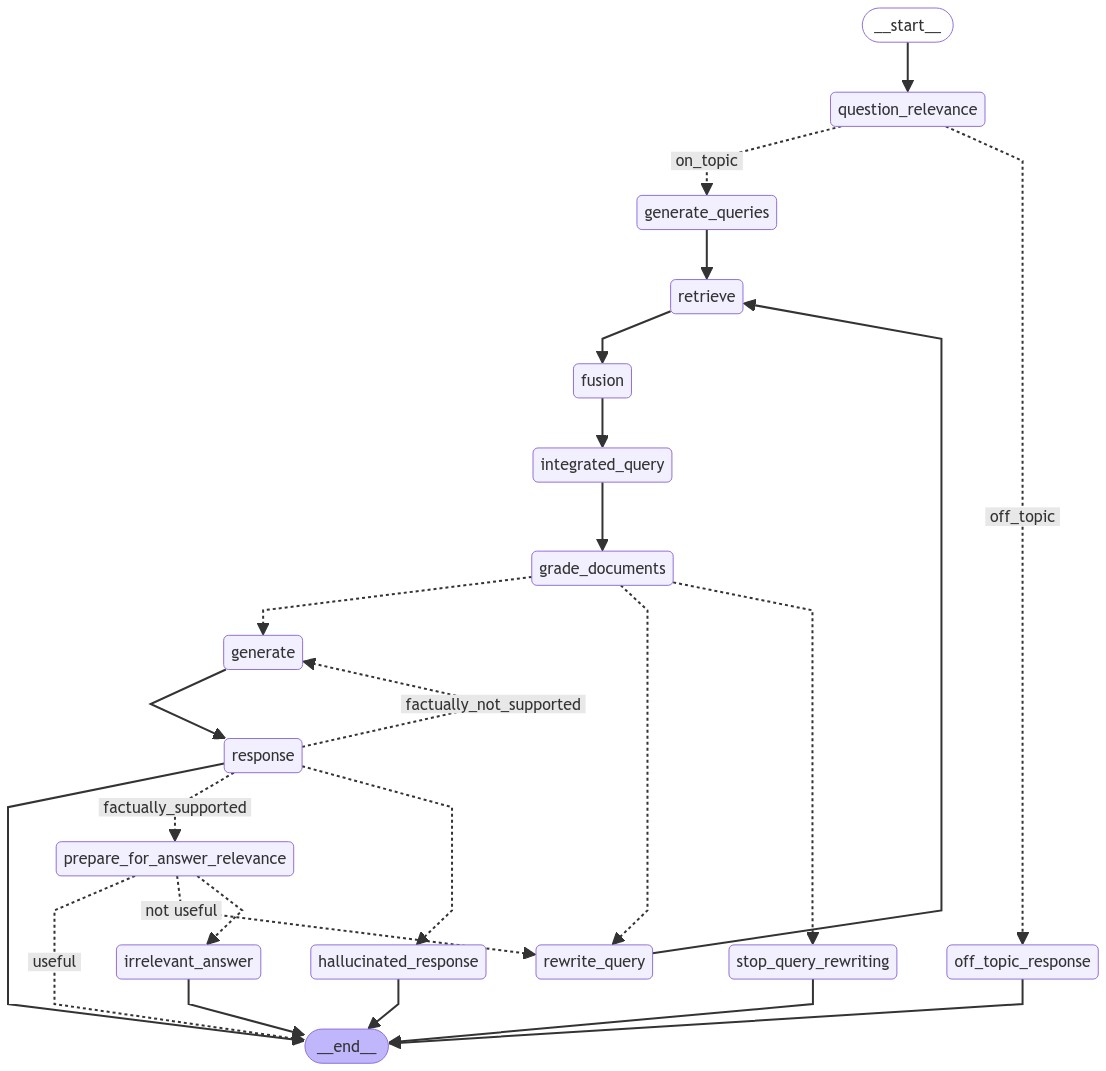

In [ ]:
from IPython.display import display, Image
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [ ]:
from pprint import pprint

inputs = {
    # "question": "What is positional embedding?",
    # "question": "What deep learning model is used in this paper?",
    # "question": "Where is scuderia car parts located?",
    # "question": "What is the Vision Transformer (ViT) model?"
    # "question": "Write a python code to add two numbers?",
    # "question": "Give a brief summary of the paper.",
    "question": "What is the abstract of the paper?",
    # "question": "What is the future scope of the paper?",

    "generated_query_num": 2,
    "No_of_query_rewriting_trials": 4,
    "No_of_hallucination_trials": 3,
    "No_of_answer_relevance_trials": 3,
}

# Initialize StateGraph
# try:
#     state_graph = StateGraph(**inputs)
# except TypeError as e:
#     print(f"Error initializing StateGraph: {e}")
#     print(f"Inputs: {inputs}")

for output in app.stream(inputs, {"recursion_limit": 30}):
    for key, value in output.items():
        # Node
        pprint(f"Output from node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n------------\n")


 --- Question Classifier --- 

#question 
##question  What is the abstract of the paper?
result  Yes

 --- On Topic Router --- 

on_topic  Yes
"Output from node 'question_relevance':"
'\n------------\n'
--- generated_queries ---
question What is the abstract of the paper?

Original Question + Generated Questions =====================

0. What is the abstract of the paper?

What is the summary of the paper?

What is the synopsis of the paper?


"Output from node 'generate_queries':"
'\n------------\n'
--- retrieve ---
"Output from node 'retrieve':"
'\n------------\n'
--- fusion ---

Top 3 search scores =========================

Document 1: 0.09679098150806242

Document 2: 0.04839549075403121


"Output from node 'fusion':"
'\n------------\n'
--- query integration ---

Integrated question: What is the abstract, summary, or synopsis of the paper?

"Output from node 'integrated_query':"
'\n------------\n'
--- grade_documents --- 

Evaluation of relevance for each document ================

In [ ]:
# Final generation
pprint(value['message'][0])

'Please rewrite your query differently and wait for the answer.'
